# Online learning of a dictionary of parts of faces

This example uses a large dataset of faces to learn a set of 20 x 20 images patches that constitute faces.

From the programming standpoint, it is interesting because it shows how to use the online API of the scikit-learn to process a very large dataset by chunks. The way we proceed is that we load an image at a time and extract randomly 50 patches from this image. Once we have accumulated 500 of these patches (using 10 images), we run the partial_fit method of the online KMeans object, MiniBatchKMeans.

The verbose setting on the MiniBatchKMeans enables us to see that some clusters are reassigned during the successive calls to partial-fit. This is because the number of patches that they represent has become too low, and it is better to choose a random new cluster.

In [ ]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

In [ ]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True)
patch_size = (20, 20)

buffer = []

In [ ]:
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

# Plot the results

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    print(patch.min())
    print(patch.max())
    break

plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Try with small GeoLife

In [1]:
import os
import sys
import inspect
from pathlib import Path

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

In [2]:
from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

In [3]:
data_dir ="/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data" # "/network/scratch/s/sara.ebrahim-elkafrawy/" #
split = "train"
use_ffcv_loader = False
bands = ["rgb"] 
batch_size = 1
num_workers = 0
patch_size = (10, 10)
num_feats = 64

In [4]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

In [5]:
len(geo_train_loader)

2004

In [6]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=num_feats, random_state=rng, verbose=True)


buffer = []

Learning the dictionary... 


In [ ]:
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for batch in geo_train_loader:
        patches, target, meta = batch
        img_np = patches['rgb'].numpy()
        img_np = img_np.squeeze(0)
        img_np = np.einsum('ijk->jki', img_np)

        data = extract_patches_2d(img_np, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
#         print(data.shape)
        if index % 100 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 10000 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(geo_train_loader)))

dt = time.time() - t0
print("done in %.2fs." % dt)

In [ ]:
# done in 44132.36s.  whole dataset

In [12]:
kmeans_np = np.load('kmeans_64_whole.npy')
dt = 44132.36

In [10]:
kmeans_np.min()

-1.899466

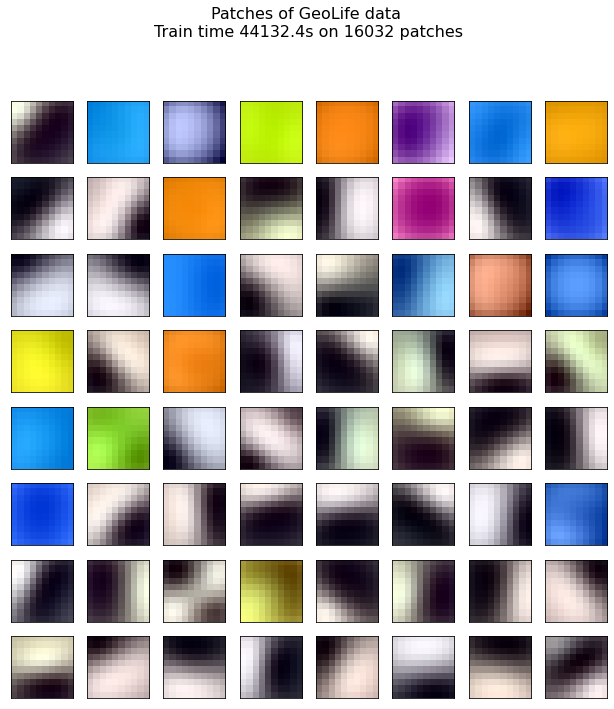

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, patch in enumerate(kmeans_np): #kmeans.cluster_centers_):
    plt.subplot(8, 8, i + 1)
    img = patch.reshape(patch_size[0], patch_size[1],3)
    img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
    img = np.clip(img, 0, 1)
    plt.imshow(img) #interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of GeoLife data \nTrain time %.1fs on %d patches" % (dt, 8 * len(geo_train_loader)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

# plt.show()
plt.savefig('patches_1st_layer.png')

In [ ]:
np.save('kmeans_64_whole.npy', kmeans.cluster_centers_)